In [17]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os
import shutil
import random
import joblib

## Train_test_split


In [2]:
source_dir = 'Data'  
train_dir = 'Train_data'    
val_dir = 'Val_Data' 
train_csv = "train.csv"
val_csv = "val.csv"

In [3]:
split_ratio = 0.75  # Proportion of files in the train set 

# Create train and test directories 
if os.path.exists(train_dir):
    try:
        shutil.rmtree(train_dir)
    except OSError as e:
        print(f"Error removing directory '{train_dir}': {e}")
if os.path.exists(val_dir):
    try:
        shutil.rmtree(val_dir)
    except OSError as e:
        print(f"Error removing directory '{val_dir}': {e}")
        
os.makedirs(train_dir)
os.makedirs(val_dir)

# Get list of all files in the source directory, excluding those with "store" in the filename
all_files = [f for f in os.listdir(source_dir) if "store" not in f]
random.shuffle(all_files)  # Shuffle files randomly

# Calculate the split index
split_index = int(len(all_files) * split_ratio)

# Split files into train and test
train_files = all_files[:split_index]
test_files = all_files[split_index:]

# Copy files to the respective directories
for file_name in train_files:
    shutil.copy(os.path.join(source_dir, file_name), os.path.join(train_dir, file_name))

for file_name in test_files:
    shutil.copy(os.path.join(source_dir, file_name), os.path.join(val_dir, file_name))

print(f"Copied {len(train_files)} files to {train_dir}")
print(f"Copied {len(test_files)} files to {val_dir}")


Copied 270 files to Train_data
Copied 90 files to Val_Data


In [4]:
labels_map= {"UP": 0, "DOWN": 1, "RIGHT": 2, "LEFT": 3, "FRONT": 4, "BACK": 5, "ROTATELEFT": 6, "ROTATERIGHT": 7, "LAND": 8}
train_labels=[]
val_labels=[]
for file in os.listdir(train_dir):
    label=file.split("_")[0]
    n=file.split('.')[0]
    train_labels.append((n,labels_map[label.upper()]))
for file in os.listdir(val_dir):
    label=file.split("_")[0]
    n=file.split('.')[0]
    val_labels.append((n,labels_map[label.upper()]))

In [5]:
import csv

# Write train_labels to CSV
with open(train_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["filename", "label"])  # Header
    writer.writerows(train_labels)

# Write val_labels to CSV
with open(val_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["filename", "label"])  # Header
    writer.writerows(val_labels)

print(f"Train labels saved to {train_csv}")
print(f"Validation labels saved to {val_csv}")

Train labels saved to train.csv
Validation labels saved to val.csv


In [6]:
train_labels = pd.read_csv(train_csv) 
val_labels = pd.read_csv(val_csv) 

## Loading Data 

In [10]:
# Function to load dataset
def load_data(label_df, data_dir):
    # Empty lists to store features and labels
    features = []
    labels = []

    for _, row in label_df.iterrows():
        filename = os.path.join(data_dir, row['filename']+".csv" )
        

        # Read file into pandas dataframe
        df = pd.read_csv(filename)
        df = df.head(395)

        # Keep only accelerometer and gyroscope signals
        data = df[['Acce_X', 'Acce_Y', 'Acce_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z']].values.astype(np.float32)
        

        # Normalize data
        data = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))

        # Populate lists with normalized data and labels
        features.append(data.flatten())
        labels.append(int(row['label']))

    return np.array(features), np.array(labels)

## Training SVM model

In [21]:
def train_and_evaluate_svm(X_train, y_train, X_test, y_test):
    # Create the SVM classifier
    svm_classifier = SVC(kernel='rbf')

    # Train the classifier
    svm_classifier.fit(X_train, y_train)

    # Perform prediction on the train and test set
    y_train_pred = svm_classifier.predict(X_train)
    y_val_pred = svm_classifier.predict(X_test)

    # Evaluate the model
    train_accuracy = accuracy_score(y_train, y_train_pred)
    val_accuracy = accuracy_score(y_test, y_val_pred)
    print(f'SVM Training accuracy: {train_accuracy:.3%}')
    print(f'SVM Validation accuracy: {val_accuracy:.3%}')
    reverse_labels_map = {value: key for key, value in labels_map.items()}
    class_names = [reverse_labels_map[i] for i in range(len(reverse_labels_map))]

    # Generate the confusion matrix with all labels
    conf_matrix = confusion_matrix(y_test, y_val_pred)
    joblib.dump(svm_classifier, 'svm_model.pkl')

    sns.heatmap(conf_matrix, annot=True, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix for Validation Data')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()



In [22]:
# Create the train and test sets
X_train, y_train = load_data(train_labels, train_dir)
X_test, y_test = load_data(val_labels, val_dir)

## Training and Evaluating SVM

SVM Training accuracy: 100.000%
SVM Validation accuracy: 98.889%


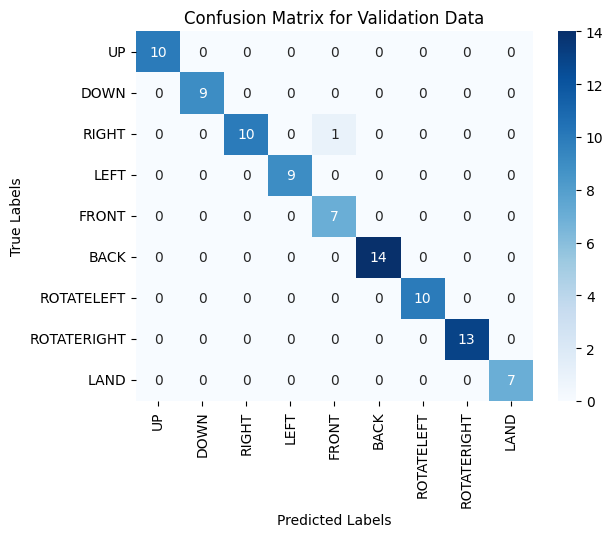

In [23]:
# Perform training and testing with SVM
train_and_evaluate_svm(X_train, y_train, X_test, y_test)